<a href="https://colab.research.google.com/github/haitongw/MIE1517_Project/blob/main/distracted_driver_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIE 1517 Project : Distracted Driver Detection

According to the CDC motor vehicle safety division, one in five car accidents is caused by a distracted driver. Sadly, this translates to 425,000 people injured and 3,000 people killed by distracted driving every year.

State Farm hopes to improve these alarming statistics, and better insure their customers, by testing whether dashboard cameras can automatically detect drivers engaging in distracted behaviors. Given a dataset of 2D dashboard camera images, State Farm is challenging Kagglers to classify each driver's behavior. Are they driving attentively, wearing their seatbelt, or taking a selfie with their friends in the backseat?

## Data Loading and Splitting

In [95]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import copy
import time
from distutils.dir_util import copy_tree

In [98]:
torch.manual_seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip /content/gdrive/MyDrive/MIE\ 1517\ Project/training\ set.zip

Streaming output truncated to the last 5000 lines.
  inflating: training set/train/c7/img_56661.jpg  
  inflating: training set/train/c7/img_56699.jpg  
  inflating: training set/train/c7/img_56717.jpg  
  inflating: training set/train/c7/img_56724.jpg  
  inflating: training set/train/c7/img_56768.jpg  
  inflating: training set/train/c7/img_56779.jpg  
  inflating: training set/train/c7/img_56849.jpg  
  inflating: training set/train/c7/img_56899.jpg  
  inflating: training set/train/c7/img_56938.jpg  
  inflating: training set/train/c7/img_5706.jpg  
  inflating: training set/train/c7/img_57076.jpg  
  inflating: training set/train/c7/img_57122.jpg  
  inflating: training set/train/c7/img_57137.jpg  
  inflating: training set/train/c7/img_5715.jpg  
  inflating: training set/train/c7/img_57278.jpg  
  inflating: training set/train/c7/img_57321.jpg  
  inflating: training set/train/c7/img_57345.jpg  
  inflating: training set/train/c7/img_57355.jpg  
  inflating: training set/train/c

In [4]:
!pip install split-folders

In [5]:
import splitfolders

data_dir = '/content/training set/train'
splitfolders.ratio(data_dir, output="output", ratio=(0.8, 0.1, 0.1)) 

Copying files: 22424 files [00:11, 2028.90 files/s]


In [6]:
train_dir = '/content/output/train'
val_dir = '/content/output/val'
test_dir = '/content/output/test'

# classes are folders in each directory with these names
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [103]:
# load and transform data using ImageFolder

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), 
                                                          (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num test images: ', len(test_data))

Num training images:  17934
Num validation images:  2237
Num test images:  2253


In [41]:
def get_dataloader(batch_size):
    loader = {}
    loader['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                                shuffle=True)
    loader['val'] = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                             shuffle=True)
    loader['test'] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                              shuffle=True)
    return loader

In [104]:
loader = get_dataloader(64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

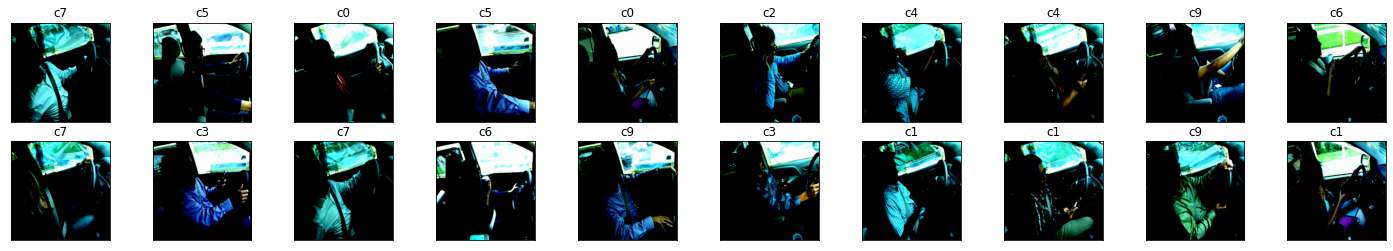

In [101]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(loader['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Data Visualization 

In [ ]:
dataset = pd.read_csv('driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


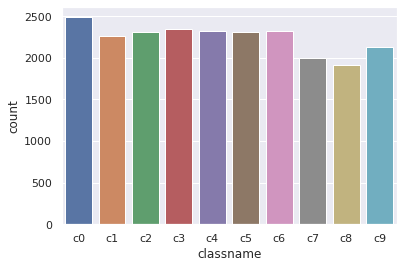

In [ ]:
# Number of images by category

import seaborn as sns

sns.set_theme(style="darkgrid")
sns.countplot(x = 'classname', data=dataset)

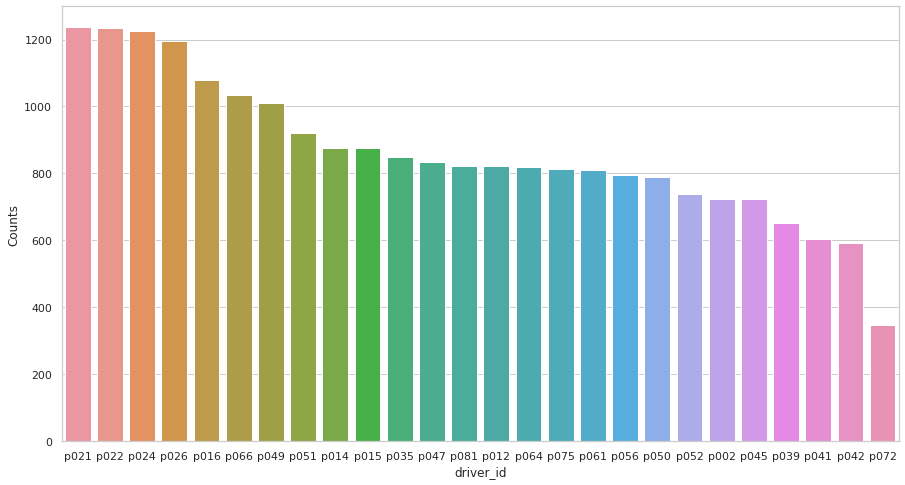

In [ ]:
# Find the frequency of images per driver

drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']

plt.figure(figsize=(15,8))
sns.barplot(x="driver_id",y="Counts", data = drivers_id)

## Models

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
!nvidia-smi

cuda:0
Sat Mar  5 18:40:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    36W / 250W |  14449MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

In [38]:
alexnet = models.alexnet(pretrained=True)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [105]:
for x, y in loader['train']:
    print(x.shape)
    y_hat = alexnet.features(x)
    print(y_hat.shape)
    break

torch.Size([64, 3, 480, 640])
torch.Size([64, 256, 14, 19])


In [114]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = 'alexnet'
        
        alex = models.alexnet(pretrained=True)  # load Alexnet
        for param in alex.parameters():
            param.requires_grad = False         # freeze all the network

        self.features = alex.features           # use the convolutional layers
        self.conv1 = nn.Conv2d(256, 256, 5, 2)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(256 * 2 * 4, 256)
        self.linear2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.features(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 256 * 2 * 4)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = x.squeeze()
        return x


In [109]:
cnn = CNNModel()
for x, y in loader['train']:
    print(x.shape)
    y_hat = cnn(x)
    print(y_hat.shape)
    break

torch.Size([64, 3, 480, 640])
torch.Size([64, 256, 2, 4])
torch.Size([64, 10])


In [115]:
def train(args, net=None):
    """
    train the neural networks
    Args:
        args, dictionary containing all the arguments used in training
            args.model(str): Class name of the model
            args.num_epochs(int): number of epochs
            args.batch_size(int): batch size
            args.learning_rate(float): learning rate
            args.save_checkpoints(bool): save checkpoints
            args.save_dir_driver(str): saving directory in google drive
            args.verbose(bool): print intermediate losses and accuracy
            args.plot(bool): plot training curve and validation curve
            args.experiment_name(str): experiment name, used as folder name
        net, neural net to be trained
    Return:
        The best neural net in the training
    """

    dataloaders = get_dataloader(args.batch_size)

    dataset_sizes = {}
    dataset_sizes['train'] = len(train_data)
    dataset_sizes['val'] = len(val_data)
    # dataset_sizes['test'] = len(test_data)

    save_dir = "output/" + args.experiment_name + "/"
    save_dir_driver = args.save_dir_driver + args.experiment_name + '/'

    # if path does not exist, create one
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(save_dir_driver):
        os.makedirs(save_dir_driver)

    # load net
    if net is None:
        Net = globals()[args.model]
        net = Net()

    net.to(device) # send to GPU
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=args.learning_rate)

    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0

    start_time = time.time()

    train_accs, train_losses = [], []
    val_accs, val_losses = [], []

    for epoch in range(args.num_epochs):
        print('-' * 10)
        print(f"epoch {epoch}/{args.num_epochs-1}")

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # training mode
            else:
                net.eval()  # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                #track history only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_accs.append(epoch_acc.cpu().detach())
                train_losses.append(epoch_loss)
            else:
                val_accs.append(epoch_acc.cpu().detach())
                val_losses.append(epoch_loss)

            if args.verbose:
                end_str = ',' if phase == 'train' else '\n'
                print(f"{phase} Loss: {epoch_loss} Acc:{epoch_acc}", end=end_str)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc 
                best_model_wts = copy.deepcopy(net.state_dict())
            
            # save checkpoints every epoch
            if args.save_checkpoints:
                checkpoints_dir = save_dir + f"model_{net.name}_bs_{args.batch_size}_lr_{args.learning_rate}_epoch_{epoch}"
                torch.save(net.state_dict(), checkpoints_dir)

        # if (epoch + 1) % 10 == 0 and args.save_checkpoints:
        #     copy_tree(save_dir, save_dir_driver)

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc}')

    # save accuracy and loss, then copy all the data to google driver
    if args.save_checkpoints:
        np.savetxt(save_dir + f"model_{net.name}_train_acc.csv", train_accs)
        np.savetxt(save_dir + f"model_{net.name}_train_loss.csv", train_losses)
        np.savetxt(save_dir + f"model_{net.name}_val_acc.csv", val_accs)
        np.savetxt(save_dir + f"model_{net.name}_val_loss.csv", val_losses)
        copy_tree(save_dir, save_dir_driver)    # save to google driver

    # plot training curve vs validation curve
    if args.plot:
        train_accs = np.array(train_accs)
        val_accs = np.array(val_accs)
        train_losses = np.array(train_losses)
        val_losses = np.array(val_losses)

        plt.plot(np.arange(args.num_epochs, step=1), train_accs, label='train')
        plt.plot(np.arange(args.num_epochs, step=1), val_accs, label='val')
        plt.title("Train vs Validation Accuracy")
        plt.legend()
        plt.show()
        plt.plot(np.arange(args.num_epochs, step=1), train_losses, label='train')
        plt.plot(np.arange(args.num_epochs, step=1), val_losses, label='val')
        plt.title("Train vs Validation Loss")
        plt.legend()
        plt.show()

    # load the best model
    net.load_state_dict(best_model_wts)

    return net

In [112]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

----------
epoch 0/0
train Loss: 0.6555622442159854 Acc:0.7997658079625293,val Loss: 0.0564391011431327 Acc:0.9865891819400984
Training complete in 4.0m 21.499403953552246s
Best val Acc: 0.9865891819400984


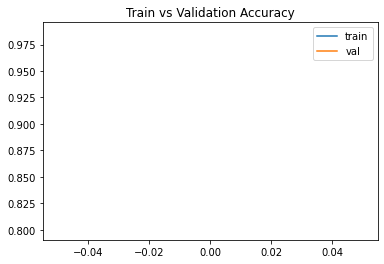

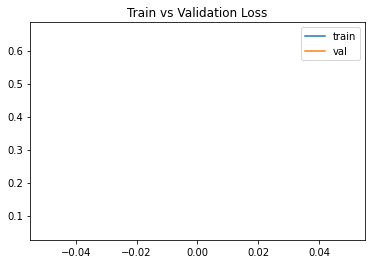

In [116]:
args = AttrDict()
args_dict = {
    'model': "CNNModel",
    'num_epochs': 1,
    'batch_size': 128,
    'learning_rate': 0.001,
    'save_checkpoints': True,
    'save_dir_driver': "/content/gdrive/MyDrive/MIE 1517 Project/output/",
    'verbose': True,
    'plot': True,
    'experiment_name': "example_1"
}
args.update(args_dict)
cnn = train(args)

----------
epoch 0/1
train Loss: 9.763521989007133 Acc:0.35374149659863946,val Loss: 0.9950570913633705 Acc:0.6137684398748324
----------
epoch 1/1
train Loss: 0.601744774227572 Acc:0.783149325303892,val Loss: 0.4092552060919997 Acc:0.8672329012069736
Training complete in 5.0m 43.2973895072937s
Best val Acc: 0.8672329012069736


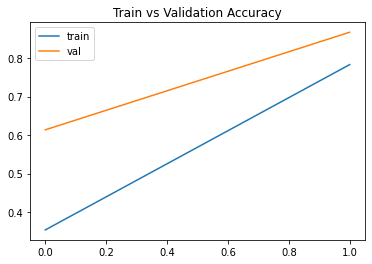

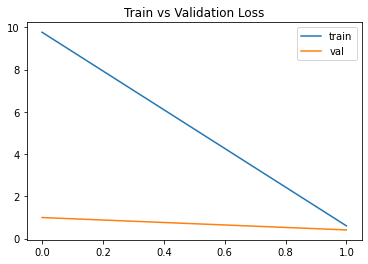

In [90]:
args = AttrDict()
args_dict = {
    'model': "CNNModel",
    'num_epochs': 2,
    'batch_size': 256,
    'learning_rate': 0.01,
    'save_checkpoints': True,
    'save_dir_driver': "/content/gdrive/MyDrive/MIE 1517 Project/output/",
    'verbose': True,
    'plot': True,
    'experiment_name': "example_2"
}
args.update(args_dict)
cnn = train(args)